In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pylab as pl
import seaborn as sns
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score

# 1. Introduction

For the final portfolio project of this programme, I decided to use a clustering method on Online Retail Customer Data. In the course of the programme I discussed the importance of customer segmentation / clustering several times with its implications on Marketing strategies. 
Therefore, in this Notebook, a "Recency, Frequency and Monetary" analysis (RFM) is conducted on an Online Retail transaction data. RFM analysis is often used in marketing and customer relationship management. It segments customers based on three key metrics: Recency (R), Frequency (F), and Monetary Value (M) of their transactions. By analyzing these metrics, businesses can identify their most valuable customers, understand their behavior, and tailor marketing strategies to optimize customer engagement and retention.

# 2. EDA

The data set is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
Each instance refers to a specific product a customer ordered at one point. Important to mention is that Invoice numbers containing a C are cancellations.

In [2]:
# load data
retail = pd.read_excel("Online Retail.xlsx")
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [3]:
print(retail.shape)

(541909, 8)


In [4]:
# check for missing values and drop them
# we drop missing values due to the fact that they are mainly customer IDs and we need to identify the customer ID to identify the customer and cluster him/her
print(retail.isna().sum())
retail = retail.dropna()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
#check for cancellations and drop them
is_cancelled = retail['InvoiceNo'].astype(str).str.startswith('C')
retail = retail[~is_cancelled]    

# 3. Data Preparation for RFM

We are going to analysis the Customers based on below 3 factors:
R (Recency): Number of days since last purchase
F (Frequency): Number of tracsactions
M (Monetary): Total amount of transactions (revenue contributed)

In [6]:
# New Attribute : Recency
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail['Diff'] = (max(retail['InvoiceDate']) - retail['InvoiceDate']).dt.days
R_grouped = retail.groupby('CustomerID')['Diff'].min().reset_index()
print(R_grouped.shape)

# New Attribute : Frequency
F_grouped = retail.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
print(F_grouped.shape)

# New Attribute : Monetary
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
M_grouped = retail.groupby('CustomerID')['Amount'].sum().reset_index()
print(M_grouped.shape)

# merge R,F,M to new dataframe
rfm = pd.merge(R_grouped, F_grouped, on="CustomerID", how='left')
rfm = rfm.merge(M_grouped, on="CustomerID", how='left')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

(4339, 2)
(4339, 2)
(4339, 2)


<AxesSubplot:>

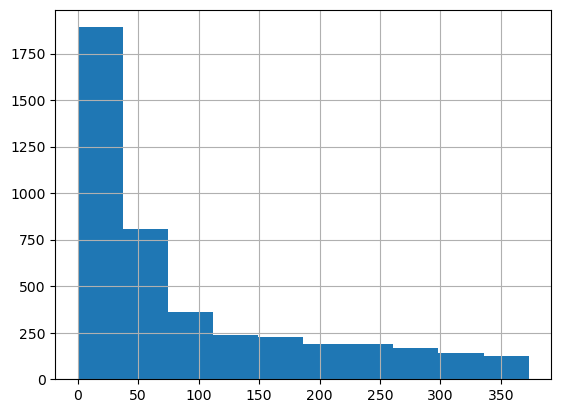

In [7]:
# Check distribution of variable
rfm['Recency'].hist()

<AxesSubplot:>

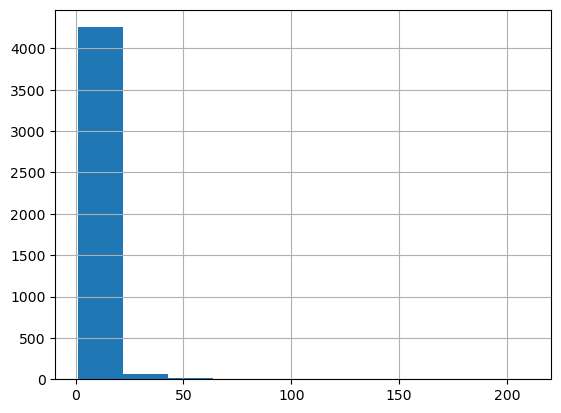

In [8]:
# Check distribution of variable
rfm['Frequency'].hist()

<AxesSubplot:>

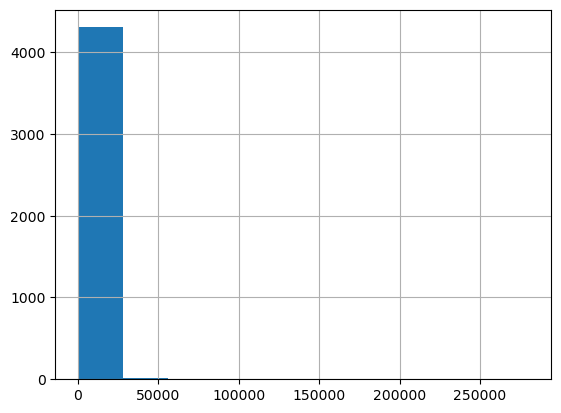

In [9]:
# Check distribution of variable
rfm['Monetary'].hist()

Text(0.5, 0, 'Features')

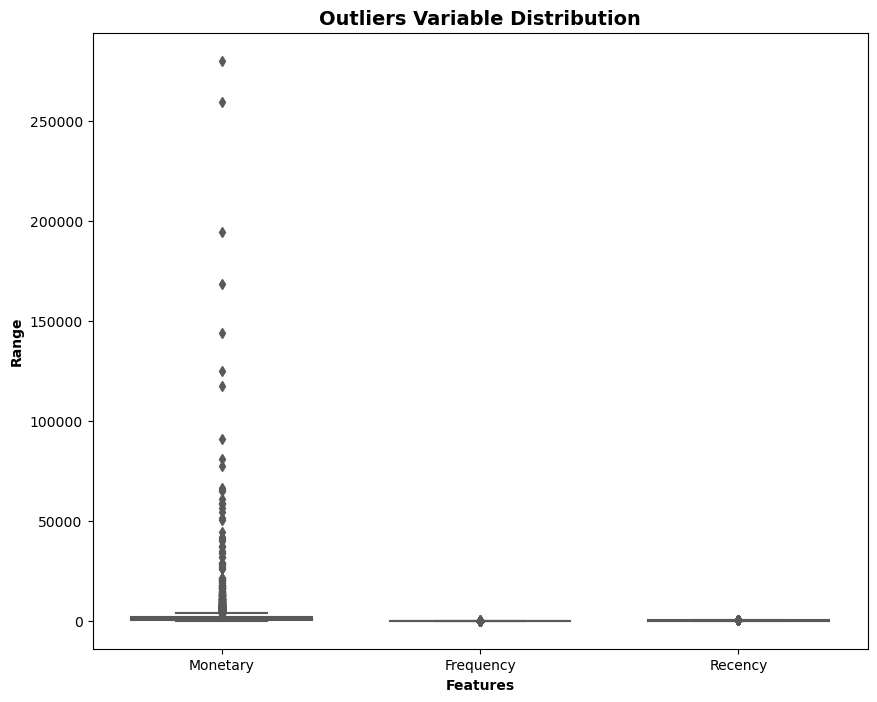

In [10]:
# Outlier Analysis of Amount Frequency and Recency

features = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[features], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Features", fontweight = 'bold')

In [11]:
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# 4. K-means Clustering

K-means clustering is a type of unsupervised learning, which is used when you have unlabelled data (i.e. data without defined categories or groups). The goal of this algorithm is to find groups in the data with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of the K groups based on the features that are provided. Data points are clustered based on the similarity in features. The results of the K-means clustering algorithm are as follows:

- The centroids of the K clusters, which can be used to label new data

- Labels for the training data (each data point is assigned to a single cluster)

Rather than defining groups before looking at the data, clustering allows to find and analyze the groups that have formed organically. The "Choosing K" i.e. Hyperparameter tuning will be discussed below.  

### 4.1 Scaling of data
It is important to rescale the data such that each variable can have a similar influence on the clustering. There are different ways to do this, there the standardization (mean 0, variance 1) is chosen for the features. We standardize our features by removing the mean and scaling to unit variance.

In [12]:
# Rescaling the attributes
df_rfm = rfm.drop(columns = {'CustomerID'},axis=1)
# Instantiate
scaler = StandardScaler()
# fit_transform
df_rfm_scaled = scaler.fit_transform(df_rfm)
df_rfm_scaled.shape

(4254, 3)

### 4.2 Hyperparameter Tuning

The hyperparameter of interest in this method is the number of clusters. We consider the Elbow curve to decide on a number of clusters. As you can see below, based on elbow curve we proceed with 3 clusters.

In [13]:
# Choos hyperparameter i.e. number of clusters
N = range(1, 10)
kmeans = []
for i in N:
    km  = KMeans(n_clusters=i)
    kmeans.append(km)
score = []
for i in range(len(kmeans)):
    score.append(kmeans[i].fit(df_rfm_scaled).score(df_rfm_scaled))

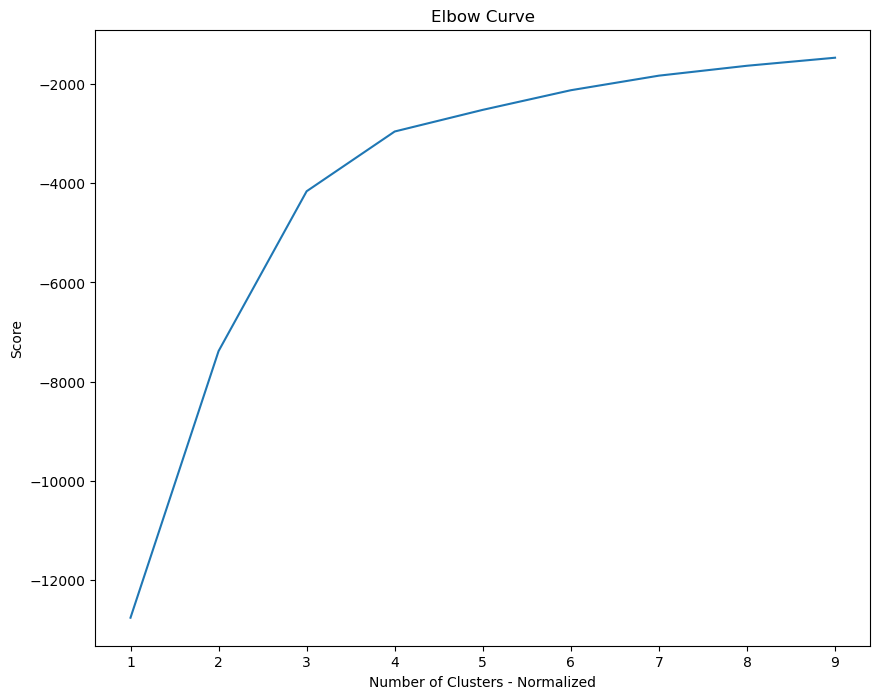

In [14]:
pl.plot(N,score)
pl.xlabel('Number of Clusters - Normalized')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show() 

### 4.3 Modeling

Training the Kmeans model can be done with Python packages and the respective cluster can be associated with the customer IDs.
We can then look at the results be e.g. boxplots to differentiate the clusters and check which values they are covering for RFM in each cluster.

In [15]:
km = KMeans(n_clusters=3)
km.fit(df_rfm_scaled)
predictions = km.predict(df_rfm_scaled)
cluster_labels = km.labels_
rfm['Cluster'] = predictions
rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,Cluster
1,12347.0,1,7,4310.00,1
2,12348.0,74,4,1797.24,0
3,12349.0,18,1,1757.55,0
4,12350.0,309,1,334.40,2
5,12352.0,35,8,2506.04,0
6,12353.0,203,1,89.00,2
7,12354.0,231,1,1079.40,2
8,12355.0,213,1,459.40,2
9,12356.0,22,3,2811.43,0
10,12357.0,32,1,6207.67,1


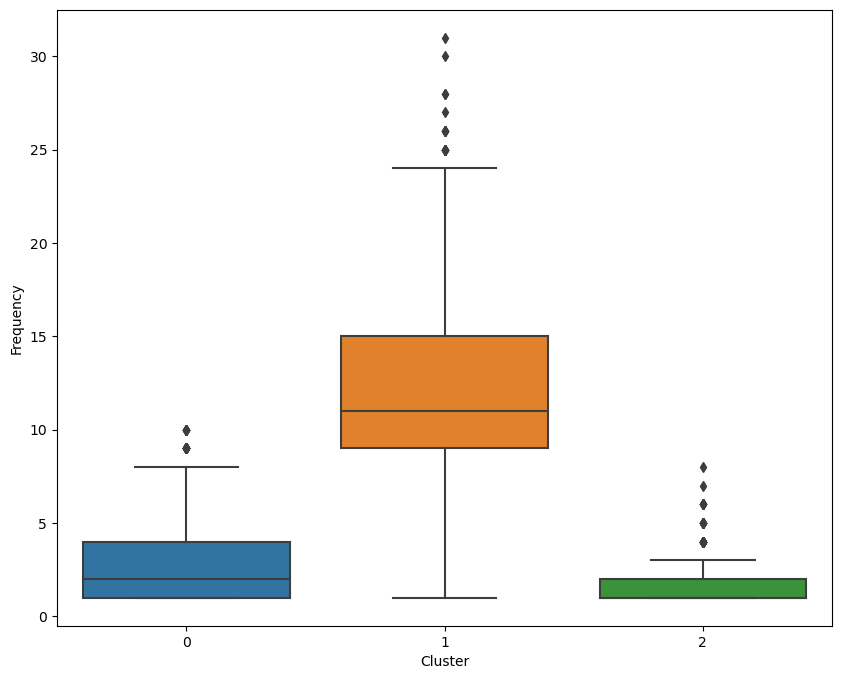

In [16]:
#Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.savefig('Frequency_plot.png')

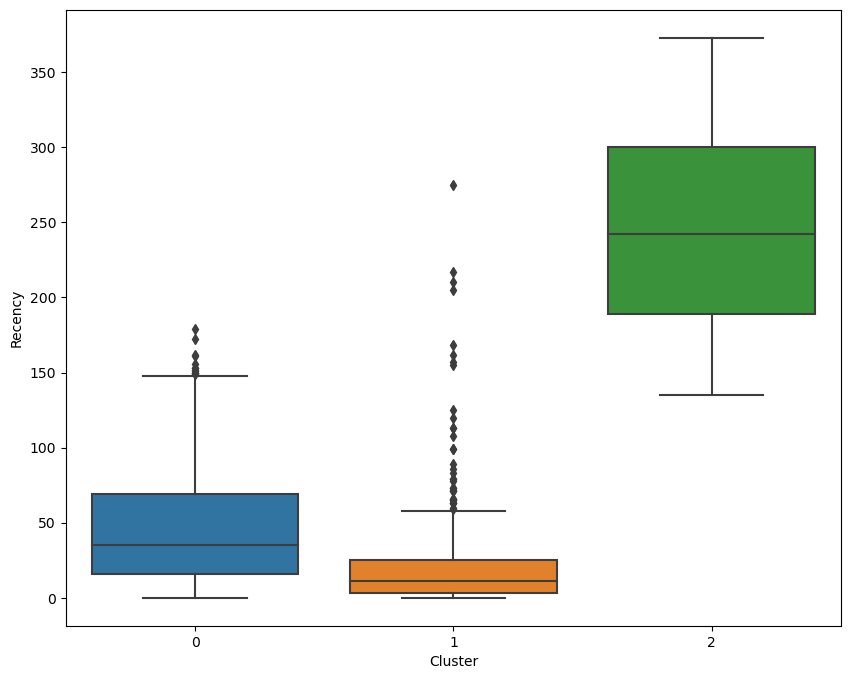

In [17]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.savefig('Recency_plot.png')

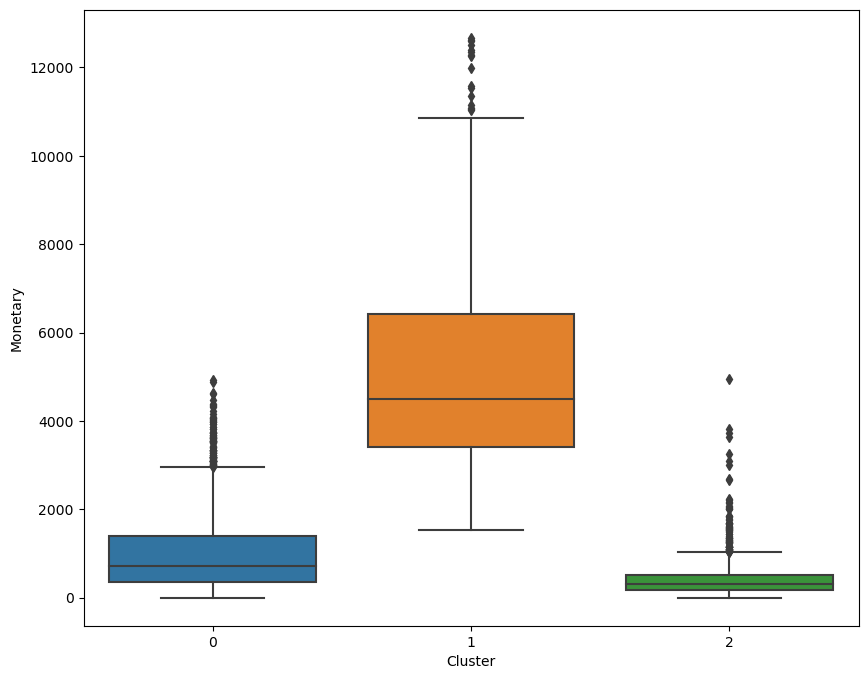

In [18]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.savefig('Monetary_plot.png')

### 4.4 Assessment of clusters

In unsupervised learning, there are no metrics like accuracy or confusion matrices you can calculate to assess the performance of your algortihm. Nevertheless there are some attempts to actually assess the similarity/dissimilarity of the clsutres. If the clustering algortihm separates dissimilar observations and clusters similar observations together, then it performs well. One metric to assess that is the silouhette coefficient.

$S = \frac{b-a}{max(a,b)}$

The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same cluster.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [19]:
# Silhouette analysis
silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
print('The silhouhette score is',silhouette_avg)

The silhouhette score is 0.5089640517590192


In [20]:
rfm.groupby('Cluster').mean().reset_index().drop(columns = {'CustomerID'},axis=1)

,Cluster,Recency,Frequency,Monetary
0,0,45.272794,3.030270,997.620574
1,1,21.063877,12.112335,5137.862863
2,2,247.364839,1.478261,430.630578


### 4.5 Interpretation and Conclusion

With a silhouette score of 0.5 the clustering performs quite well i.e. the data is relatively well separated and correctly clustered.

Cluster 0 represents customers who have not made purchases recently (247.36 days on average since last purchase) and have low buying frequency (1.48 purchases on average) with moderate monetary spending ($430.63 on average). These customers might be occasional shoppers or have reduced interest in the retailer's offerings. arketing strategies could be to try to engage them to come back - nevertheless, the profit from those customers might not be worth it so this should be kept in mind when planning the marketing strategies.

Cluster 1 represents highly active and valuable customers who made purchases recently (21.06 days on average since last purchase) and have a high frequency of purchases (12.11 purchases on average) with significantly high monetary spending ($5137.86 on average). These customers are the most loyal and contribute significantly to the retailer's revenue.

Cluster 2 represents customers with moderate recency (45.27 days on average since last purchase), moderate frequency (3.03 purchases on average), and moderate monetary spending ($997.62 on average). They may be moderately engaged or new customers, showing a balanced buying behavior. It might make sense to try to bind them with special offers/marketing efforts.

# 5. Hierarchical Clustering
For comparison, we also conduct hierarchical clustering.
Hierarchical clustering, also known as hierarchical cluster analysis, is an algorithm that groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other, and the objects within each cluster are broadly similar to each other.

Hierarchical clustering starts by treating each observation as a separate cluster. Then, it repeatedly executes the following two steps: (1) identify the two clusters that are closest together and (2) merge the two most similar clusters. This iterative process continues until all the clusters are merged together.

### 5.1 Dendogram
The main output of hierarchical clustering is a dendrogram, which shows the hierarchical relationship between the clusters. From the dendogram, we would also conclude to proceed with 3 clusters.

The choice of distance metric should be made based on theoretical concerns from the domain of study. That is, a distance metric needs to define similarity in a way that is sensible for the field of study. For example, if clustering crime sites in a city, the city block distance may be appropriate. Where there is no theoretical justification for an alternative, the Euclidean should generally be preferred, as it is usually the appropriate measure of distance in the physical world. Therefore, we proceed with the Euclidian distance which is also the default setting.

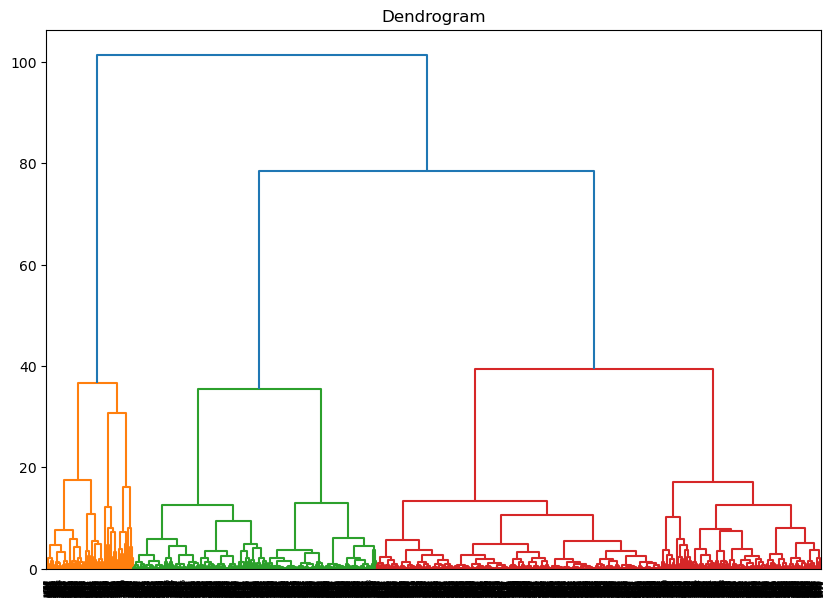

In [21]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(df_rfm_scaled , method='ward'))

### 5.2 Agglomerative Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
_ = cluster.fit_predict(df_rfm_scaled)


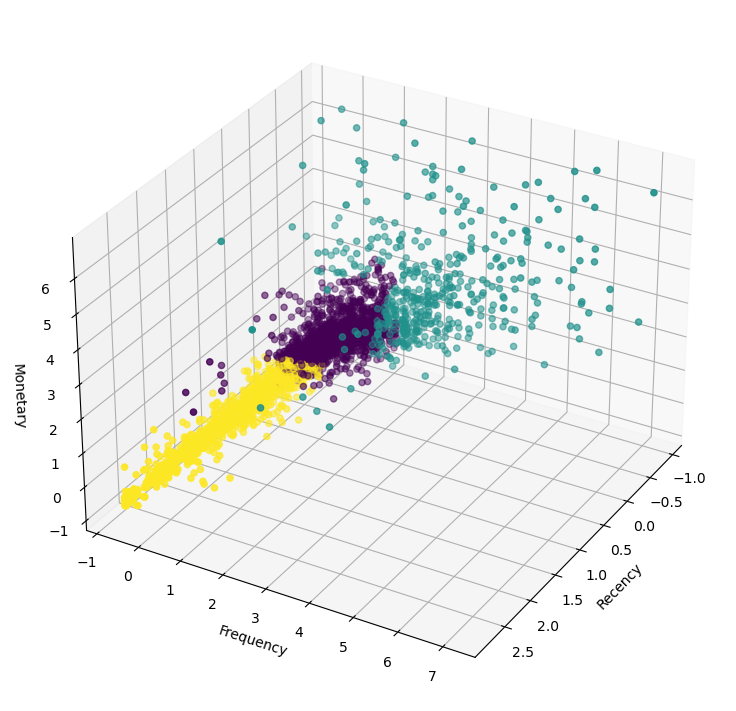

Text(0.5, 0, 'Recency')

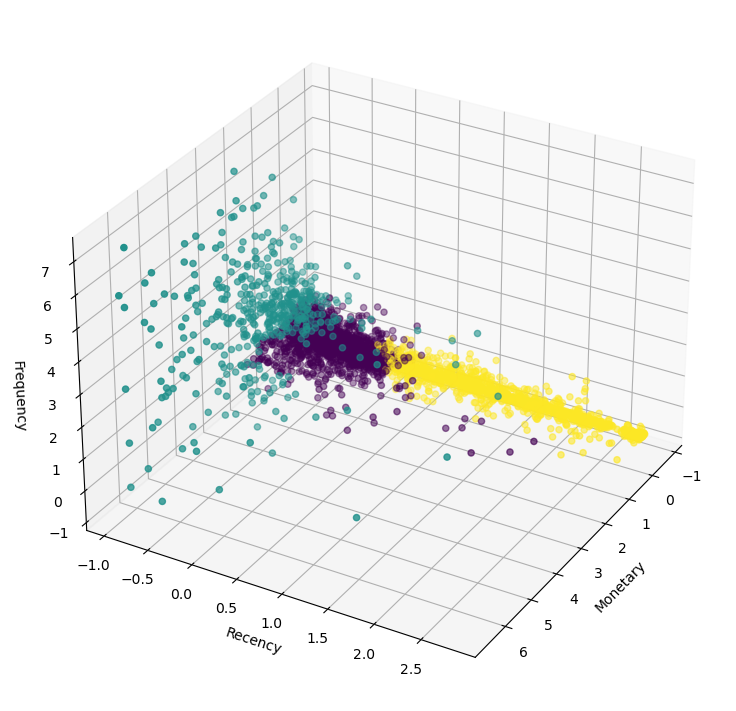

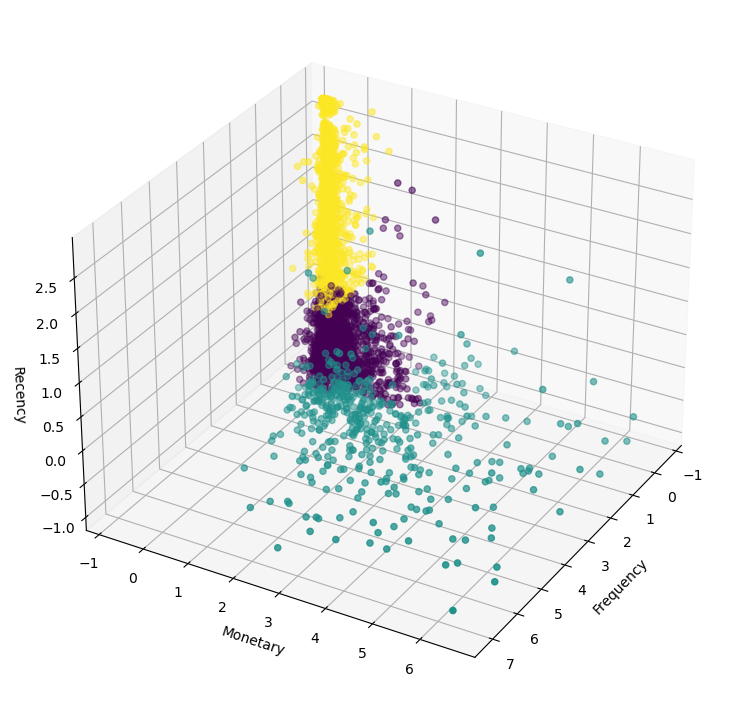

In [23]:
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
ax = plt.axes(projection='3d')
x = df_rfm_scaled[:,0]
y = df_rfm_scaled[:,1]
z = df_rfm_scaled[:,2]
ax.scatter3D(x,y,z, c=cluster.labels_)
ax.view_init(30, 30)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
ax = plt.axes(projection='3d')

ax.scatter3D(z,x,y, c=cluster.labels_)
ax.view_init(30, 30)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
ax = plt.axes(projection='3d')

ax.scatter3D(y,z,x, c=cluster.labels_)
ax.view_init(30, 30)
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')

### 5.3 Assessment of clusters and conclusion

In [24]:
# Silhouette analysis
silhouette_avg2 = silhouette_score(df_rfm_scaled, cluster.labels_)
print('The silhouhette score is',silhouette_avg2)

The silhouhette score is 0.45244100876632604


We again consider the silhouette score which is slightly below the score when we clustered with k-means. Nevertheless, the clusters seem to be quite similar to the clusters identified with k-means.

Cluster 0: The "lost" customers (lots of days since last order, low total monetary order volume, low frequency) (yellow)

Cluster 1: The most valuable customers (very recent orders, high total monetary order volume, high frequency of ordering) (green) - nevertheless it can be seen that the cluster is quite spread

Cluster 2: The new customers (recent orders, moderate total monetary order volume, limited frequency) (purple)